# Analyse von Arxiv: Strukturierte und unstrukturierte Daten

Dieses Jupyter Notebook stellt die Prüfungsaufgabe des Moduls "Maschinelles Lernen" (ROB60) der Akad University dar.

## Einführung

Die Aufgabenstellung dieser Prüfung ist es Artikel zu einem selbstgewählten Thema der Webseite [Arxiv](https://arxiv.org/) zu analysieren.
Im ersten Schritt wird ein Histogramm der über die Anzahl der Artikel pro Autor erstellt. Im Weiteren wird eine deskriptive Analyse für die verschiedenen Jahr durchgeführt.
Das Ziel ist zu eruieren, ob sich über die Jahre gewisse Parameter oder Korrelationen verändert haben. Dies könnte beispielsweise die Anzahl der veröffentlichten Artikel pro Autor
oder die Anzahl an Autoren sein. Darüber hinaus wird eine Textanalyse durchgeführt. Diese Analyse wird anhand des Abstracts der Artikel durchgeführt.
Diese Aufgaben werden sich am CRISP DM Standard orientieren und die folgenden Punkte beinhalten:

1. Verstehen der Daten (Data Understanding)
2. Datenvorbereitung (Data Preparation)
3. Modellierung (Modeling)
4. Auswertung (Evaluation)

## Extraktion und Verstehen der Daten (Data Understanding)

Für die Extraktion der Daten findet mittels der Web-API der Platform von Arxiv statt. Es wird das exemplarische Stichwort "Deep Reinforcement Learning" gewählt.
Um eine möglichst aussagekräftige Analyse durchführen zu können, werden Artikel für die Jahre 2017-2021 heruntergeladen. Pro Jahr sollen 200 Artikel heruntergeladen und in die
Analyse miteinbezogen werden.

### Beschreibung der Datenquelle und des Codes zur Extraktion

Die Platform Arxiv bietet eine Web-Api an, um Metadaten der Artikel zu extrahieren. Hierbei wird eine Anfrage an den Server mittels des Protokolls gesendet.
Die Parametrisierung findet mittels der URL statt. Für die Extraktion eben jener Daten wird das Paket `arxiv` verwendet. Es bietet eine API zur Parametrisierung der Anfrage an.
Im folgenden Code wird zunächst ein leeres Array für die extrahierten Artikel angelegt. Darüber hinaus werden die Jahreszahlen in einem Array definiert und die maximale Anzahl an Artikeln
pro Jahr. Aufgrund einer Limitation der Api, die nur maximal 200 Artikel pro Anfrage zurückliefert, werden mehrere Iterationen durchgeführt. Für jedes Jahr wird eine Suche durchgeführt und
die Metadaten Titel, Autoren, Zusammenfassung und Veröffentlichungsdatum der einzelnen Artikel einem Array hinzugefügt. Zuletzt werden die Artikel in einem Dataframe gespeichert.


In [5]:
import arxiv
import pandas as pd
from arxiv import Search

# Variables
articles = []
years = [2018, 2019, 2020, 2021]
number_of_articles = 200
client = arxiv.Client()

for year in years:

    # Define search query
    search_query = f"Deep Reinforcement Learning AND submittedDate:[{year}01010000 TO {year}12312359]"

    # Search for the articles
    search = Search(
        query=search_query,
        max_results=number_of_articles,
    )

    # Request the articles
    results = client.results(search)

    # Save retrieved data in array
    for result in results:
        article = {
            "Title": result.title,
            "Authors": [str(author) for author in result.authors],
            "Abstract": result.summary,
            "PublishedDate": result.published.date(),
        }
        articles.append(article)

# Save articles in data frame
df = pd.DataFrame(articles)

# Print types and head
print(f"Types of the data frame \n {df.dtypes}")
print(f"The head of the data frame \n {df.head()}")

Types of the data frame 
 Title            object
Authors          object
Abstract         object
PublishedDate    object
dtype: object
The head of the data frame 
                                                Title  \
0  Applications of Deep Reinforcement Learning in...   
1           Generalization and Regularization in DQN   
2       Object-sensitive Deep Reinforcement Learning   
3  Towards Symbolic Reinforcement Learning with C...   
4  Exploration by Distributional Reinforcement Le...   

                                             Authors  \
0  [Nguyen Cong Luong, Dinh Thai Hoang, Shimin Go...   
1  [Jesse Farebrother, Marlos C. Machado, Michael...   
2            [Yuezhang Li, Katia Sycara, Rahul Iyer]   
3  [Artur d'Avila Garcez, Aimore Resende Riquetti...   
4                      [Yunhao Tang, Shipra Agrawal]   

                                            Abstract PublishedDate  
0  This paper presents a comprehensive literature...    2018-10-18  
1  Deep reinforcement l

## Vorbereiten der Daten (Data Preparation)

Im folgenden Abschnitt wird eine Aufbereitung der Daten vorgenommen. Dies ist ein essenzieller Teil jedes Datenprojektes. Je besser die Daten aufbereitet wurden, desto aussagekräftiger
sind die Ergebnisse der nachfolgenden Analyse des Datenbestands. Sie wird unmittelbar nach der Extraktion der Daten vorgenommen. Hierzu gehören üblicherweise folgende Schritte:

1. Umbenennung der Spalten für eine aussagekräftigere Darstellung der Daten und des verarbeitenden Codes.
2. Entfernung irrelevanter Spalten für die weitere Verarbeitung
3. Entfernung von Duplikaten und Zeilen mit Null-Werten.
4. Entfernung von Ausreißern

Aus der Codezelle zur Datenextraktion geht hervor, dass eine Selektion und Benennung der Spalten für das DataFrame bereits stattgefunden hat. Die ersten beiden Schritte wurden somit durchgeführt.
Eine Bereinigung von Ausreißern findet in diesem DataFrame nicht statt, da außer dem Veröffentlichungsdatum keine numerischen Werte enthalten sind. Eine Bereinigung von Ausreißern wäre hier auch nicht nötig,
da die Jahreszahlen explizit bei der Abfrage parametrisiert wurden.

In der folgenden Codezelle wird nach der Extraktion eine Bereinigung der Werte hinsichtlich vorkommender Null-Werte vorgenommen. Hierzu wird die Methode `dropna` auf das DataFrame angewendet.
Zudem wird die Spalte `Authors` expandiert. Viele Artikel haben mehrere Autoren. Diese wurden im DataFrame als `list` gespeichert. Damit die Analyse hinsichtlich der Anzahl veröffentlichter Publikationen pro Autor durchgeführt werden kann,
ist es sinnvoll mit der Methode `explode` eine Expansion durchzuführen. Diese Operation wird nachfolgend exemplarisch dargestellt.

Ausgehend von der folgenden Tabelle in denen exemplarisch zwei Publikationen von mehreren Autoren verfasst wurden, sollen für jeden Autor weitere Datensätze erzeugt werden.
Die anderen Werte sollen dabei nicht verändert werden

| Titel   | Autoren            | Veröffentlichungsdatum |
|---------|--------------------|------------------------|
| Titel A | [Autor A, Autor B] | 2018                   |
| Titel B | [Autor B, Autor C] | 2019                   |

Das Ergebnis der Methode `explode` würde wie folgt aussehen:

| Titel   | Autoren | Veröffentlichungsdatum |
|---------|---------|------------------------|
| Titel A | Autor A | 2018                   |
| Titel A | Autor B | 2018                   |
| Titel B | Autor B | 2019                   |
| Titel B | Autor C | 2019                   |

Mithilfe der zweiten Tabelle kann nun eine Quantifizierung der Autoren pro Publikation durchgeführt werden.
Hierzu wird über die definierten Jahre iteriert und das DataFrame für das entsprechende Jahr gefiltert. Dies wird mit der `isin`-Methode getan.
Die zehn Autoren mit den meisten geschrieben Publikationen des entsprechenden Jahres werden auf der Spalte mit der Methode `value_counts` erhoben.
Eine Limitierung auf die 10 Autoren mit den meisten Publikation wird mit der Methode `head` durchgeführt.
Anschließend wird das Histogramm dargestellt. Die Autoren werden auf der x-Achse dargestellt. Für jeden Autor gibt es einen Balken.
Auf der y-Achse erweist sich eine Skala von 0 bis 10 als sinnvoll. Die Schrittweite beträgt 1.

In [ ]:
import matplotlib.pyplot as plt
from extraction import extract_data_from_arxiv
import pandas as pd

# Extract data from API
df = extract_data_from_arxiv()

# Ensure PublishedDate is in datetime format
df["PublishedDate"] = pd.to_datetime(df["PublishedDate"], errors="coerce")

# Drop rows with null values in Authors or PublishedDate
df = df.dropna(subset=["Authors", "PublishedDate"])

# Expand the possible multiple authors of a paper to an own entry for each author
df = df.explode(column="Authors")

# Define the years to analyze
years = range(2018, 2022)

for year in years:
    # Filter for the specific year
    year_filtered_df = df[df["PublishedDate"].dt.year == year]

    # Skip the year if no data is found
    if year_filtered_df.empty:
        print(f"No data found for year {year}. Skipping.")
        continue

    # Count authors for the selected year and take the top 10 authors with the most publications
    top_author_counts = year_filtered_df["Authors"].value_counts().head(10)

    # Plot the histogram
    top_author_counts.plot(kind="bar")
    plt.title(f"Top 10 authors for {year}")
    plt.xlabel("Author")
    plt.ylabel("Count")
    plt.yticks(range(0, max(top_author_counts.max() + 1, 11), 1))
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from calendar import month_name
from extraction import extract_data_from_arxiv
from preparation import prepare_data

# Define years and the months order
years = range(2018, 2022)

# Get a mapping of month names to their numerical values
month_order = {month: i for i, month in enumerate(month_name) if month}

# Extract and prepare data
df = extract_data_from_arxiv()
df = prepare_data(df, years, show_histograms=False)

for year in years:
    # Filter for the specific year
    year_filtered_df = df[df["PublishedDate"].dt.year == year]

    # Skip the year if no data is found
    if year_filtered_df.empty:
        print(f"No data found for year {year}. Skipping.")
        continue

    # Get number of articles per month and sort the series by the index
    articles_per_month = (year_filtered_df["PublishedDate"].groupby(year_filtered_df["PublishedDate"].dt.month_name())
                                                           .count()
                                                           .reindex(month_order, fill_value=0))

    # Plot the histogram
    articles_per_month.plot(kind="bar")
    plt.title(f"Number of articles per month for {year}")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.yticks(range(0, max(articles_per_month.max() + 1, 11), 10))
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from calendar import month_name
from extraction import extract_data_from_arxiv
from preparation import prepare_data

# Define years and the months order
years = range(2018, 2022)

# Get a mapping of month names to their numerical values
month_order = {month: i for i, month in enumerate(month_name) if month}

# Extract and prepare data
df = extract_data_from_arxiv()
df = prepare_data(df, years, show_histograms=False)

for year in years:
    # Filter for the specific year
    year_filtered_df = df[df["PublishedDate"].dt.year == year]

    # Skip the year if no data is found
    if year_filtered_df.empty:
        print(f"No data found for year {year}. Skipping.")
        continue

    # Get number of authors per month and sort the series by the index
    authors_per_month = (year_filtered_df.groupby(year_filtered_df["PublishedDate"].dt.month_name())["Authors"]
                                         .nunique()
                                         .reindex(month_order, fill_value=0))

    # Plot the histogram
    authors_per_month.plot(kind="bar")
    plt.title(f"Number of authors per month for {year}")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.yticks(range(0, max(authors_per_month.max() + 1, 11), 10))
    plt.show()

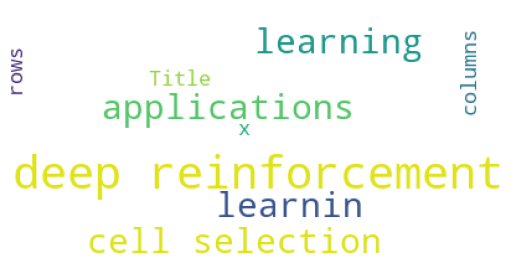

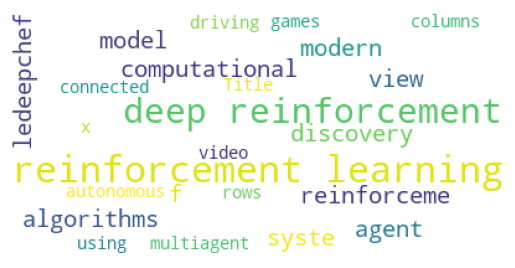

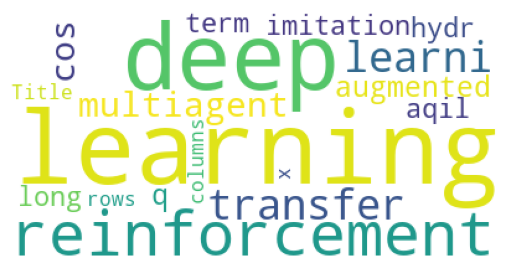

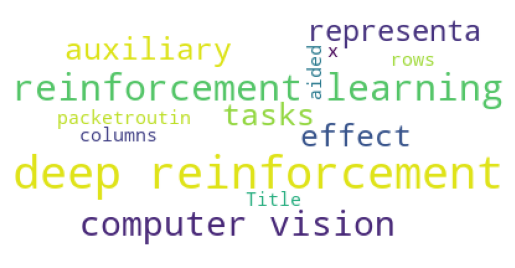

In [10]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from extraction import extract_data_from_arxiv
from preparation import prepare_data

# Define the relevant years for the analysis
years = range(2018, 2022)

# Extract and prepare data
df = extract_data_from_arxiv()
df = prepare_data(df, years, show_histograms=False)

# Clean the titles from special chars and lower the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

for year in years:

    # Filter for the specific year
    year_filtered_df = df[df["PublishedDate"].dt.year == year]

    # Clean the title from special characters
    cleaned_df = pd.DataFrame(year_filtered_df["Title"].apply(clean_text))

    # Set the stop words
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(
        background_color="white",
        stopwords=stopwords,
        max_words=500,
        max_font_size=100,
        random_state=100,
    ).generate(str(cleaned_df))

    # Print the wordcloud
    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()